# Setup

In [ ]:
!pip install patchify

In [ ]:
import numpy as np

# U-Net Architecture

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    #model.summary()

    return model


# Dataset Loading & Preprocessing

In [ ]:
from pathlib import Path
import shutil
import imghdr

IMG_EXTS = ['jpeg','jpg', 'bmp', 'png']

def remove_invalid_images(data_dir):
  for image_class in os.listdir(data_dir):
      for image in os.listdir(os.path.join(data_dir, image_class)):
          image_path = os.path.join(data_dir, image_class, image)
          try:
              tip = imghdr.what(image_path)
              if tip not in IMG_EXTS:
                  print('Image not in ext list {}'.format(image_path))
                  os.remove(image_path)
          except Exception as e:
              print('Issue with image {}'.format(image_path))
              os.remove(image_path)

In [ ]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects-top

Git LFS initialized.
fatal: destination path 'architects-top' already exists and is not an empty directory.


In [ ]:
!git clone https://github.com/cvjena/labelmefacade.git

In [ ]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# root_directory = 'facades-dataset/'
root_directory = '/content/labelmefacade'

patch_size = 256

#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.

image_dataset = []

count = 0

for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':   #Find all 'images' directories
        images = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".jpg"):   #Only read jpg images...
                image = cv2.imread(f"{path}/{image_name}", 1)  #Read each image as BGR
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                image = image.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                image = np.array(image)

                #Extract patches from each image
                print("Now patchifying image:", f"{path}/{image_name}")
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)



count = 0
 #Now do the same as above for masks
 #For this specific dataset we could have added masks to the above code as masks have extension png
mask_dataset = []
for path, subdirs, files in os.walk(root_directory):
    #print(path)
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'labels':   #Find all 'images' directories
        masks = sorted(os.listdir(path))  #List of all image names in this subdirectory
        for i, mask_name in enumerate(masks):
            if mask_name.endswith(".png"):   #Only read png images... (masks in this dataset)
                mask = cv2.imread(f"{path}/{mask_name}", 1)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
                mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation
                mask = np.array(mask)

                print("Now patchifying mask:", f"{path}/{mask_name}")
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)

Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010736.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010738.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010739.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010740.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010741.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010744.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010745.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010747.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010748.jpg
Now patchifying image: /content/labelmefacade/images/05june05_static_street_boston__p1010749.jpg
Now patchifying image: /conten

In [ ]:
image_dataset = np.array(image_dataset[:50])
mask_dataset = np.array(mask_dataset[:50])

In [ ]:
image_dataset.shape, mask_dataset.shape

((50, 256, 256, 3), (50, 256, 256, 3))

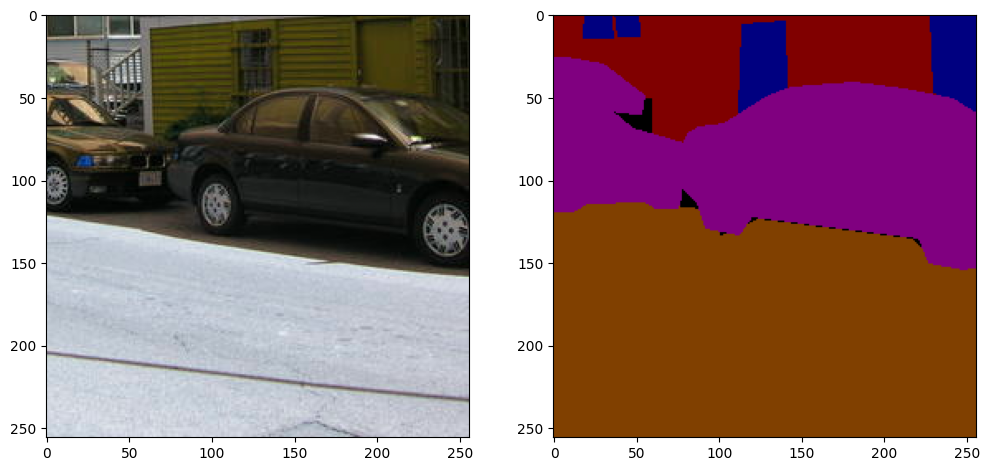

In [ ]:
import random

image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [ ]:
# Define RGB values for each class
class_colors = {
    (0, 0, 0): 0,        # various
    (128, 0, 0): 1,      # building
    (128, 0, 128): 2,    # car
    (128, 128, 0): 3,    # door
    (128, 128, 128): 4,  # pavement
    (128, 64, 0): 5,     # road
    (0, 128, 128): 6,    # sky
    (0, 128, 0): 7,      # vegetation
    (0, 0, 128): 8       # window
}

# Example RGB image (3 channels)
rgb_image = np.array([
    [[128, 0, 0], [0, 128, 128]],
    [[0, 0, 0], [128, 128, 128]]
])

# Convert RGB image to single-channel image containing class labels
def rgb_to_labels(rgb_image, class_colors):
    labels_image = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for i in range(rgb_image.shape[0]):
        for j in range(rgb_image.shape[1]):
            # print(rgb_image[i, j])
            rgb = tuple(rgb_image[i, j])
            labels_image[i, j] = class_colors.get(rgb, 255)  # Set to 255 if RGB not found in class_colors
    return labels_image

In [ ]:
from keras.utils import to_categorical

labels = np.array([rgb_to_labels(mask, class_colors) for mask in mask_dataset])

n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)

In [ ]:
labels_cat.shape

(50, 256, 256, 9)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size =0.2, random_state=42)

# Training

In [ ]:

# import segmentation_models as sm
# weights = np.full(n_classes, 1 / n_classes)
# dice_loss = sm.losses.DiceLoss(class_weights=weights)
# focal_loss = sm.losses.CategoricalFocalLoss()
# total_loss = dice_loss + (1 * focal_loss)  #


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
# model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model.summary()


history1 = model.fit(X_train, y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 256, 256, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 256, 256, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 256, 256, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

# Testing

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


# Using built in keras function for IoU
from keras.metrics import MeanIoU

# n_classes = 9
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

1/1 [==============================] - 2s 2s/step
Mean IoU = 0.1745909


In [ ]:
import cv2

def read_img(image_path):
    patch_size = 256
    image = cv2.imread(image_path, 1)  #Read each image as BGR
    SIZE_X = (image.shape[1] // patch_size) * patch_size
    SIZE_Y = (image.shape[0] // patch_size) * patch_size
    image = Image.fromarray(image)
    image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
    image = image.resize((SIZE_X, SIZE_Y))  # Try not to resize for semantic segmentation
    return np.array(image)


image_path = '/content/architects-top/all/Mimar Kemalettin/00147.jpg'
image_path = '/content/architects-top/all/Mimar Kemalettin/00113.jpg'
image_path = '/content/architects-top/all/Mimar Kemalettin/00309.jpg'

# Load the image
image = read_img(image_path)

1/1 [==============================] - 2s 2s/step


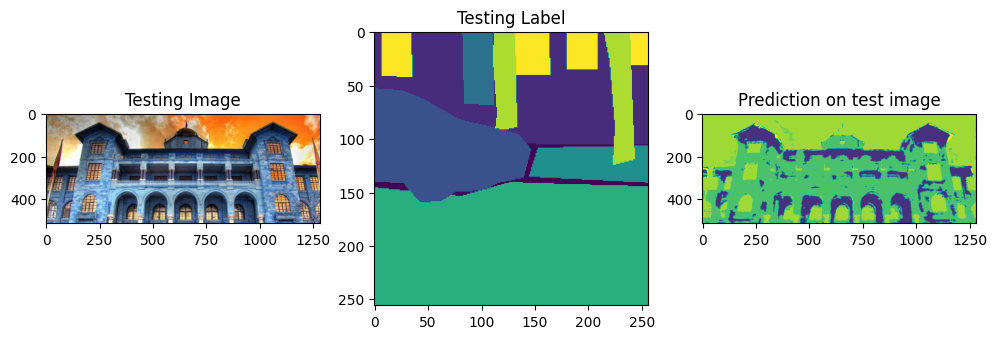

In [ ]:
# Predict on a few images
import random

test_img_number = random.randint(0, len(X_test))
# test_img = X_test[test_img_number]
test_img = image

ground_truth = y_test_argmax[test_img_number]
#test_img_norm = test_img[:,:,0][:,:,None]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input))
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()